# Anomaly Detection

The identification of data points, items, observations or events that do not conform to the expected pattern of a given group. 

## What are Anomalies?
 
- **Anomalies:** Occur very infrequently, i.e. the less likely something is to occur, the more likely it is to be an anomaly.  

- **Use cases:**  response times (longer than usual), error rates (more than usual), network load, cyber intrusions, fraud

- **Point anomalies:**  A single instance of data is anomalous if it's too far off from the rest. E.g. detecting data exfiltration based on GB leaving the network, detecting credit card fraud based on "amount spent."

- **Contextual anomalies:** The abnormality is context specific. This type of anomaly is common in time-series data. E.g. accessing confidential files during work hours is normal, but in the middle of the night is odd.

- **Collective anomalies:**  A set of data instances collectively helps in detecting anomalies. E.g. someone is trying to copy data form a remote machine to a local host unexpectedly, an anomaly that would be flagged as a potential cyber attack. The combination of the event from the remote machine and the event from the local host combine to detect the anomaly. 

- **Anomalies vs. Noise Removal vs. Novelty Detection:** Novelty detection is concerned with identifying an unobserved pattern in new observations not included in training data — like a sudden interest in a new channel on YouTube during Christmas, for instance. Noise removal (NR) is the process of immunizing analysis from the occurrence of unwanted observations; in other words, removing noise from an otherwise meaningful signal. 

https://www.datascience.com/blog/python-anomaly-detection

## Techniques for identifying/detecting anomalies

### Statistical Methods

- Flag the data points that deviate from the expected, based on the statistical properties, such as mean, median, mode, and quantiles. 

- You could define an anomalous data point as one that deviates by a certain standard deviation from the mean. 

- You could use a simple or exponential moving average to smooth short-term fluctuations and highlight long-term ones.  

- This method is challenging with really noisy data. 

### Support Vector Machine & Isolation Forest Anomaly Detection 

- There are extensions to the supervised technique, such as OneClassSVM, that can be used to identify anomalies as an unsupervised problems (in which training data are not labeled). 

- The algorithm learns a soft boundary in order to cluster the normal data instances using the training set, and then, using the testing instance, it tunes itself to identify the abnormalities that fall outside the learned region.
    
### Clustering-Based Anomaly Detection 

- Assumption: Data points that are similar tend to belong to similar groups or clusters, as determined by their distance from local centroids.

- K-means creates 'k' similar clusters of data points. Data instances that fall into abnormally small clusters could potentially be marked as anomalies.

- Using density based clustering, like DBSCAN, we can design the model such that the data points that do not fall into a cluster are the anomalies. 


### Density-Based Anomaly Detection 

- Assumption: Normal data points occur around a dense neighborhood and abnormalities are far away. 

- The nearest set of data points are evaluated using a score, using one of two algorithms:
    
    - KNN: K-nearest neighbor
    - LOF: Local Outlier Factor, aka the relative density of data which is based on the reachability distance.

In [78]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from numpy import linspace, loadtxt, ones, convolve
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd
import collections
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
style.use('fivethirtyeight')
%matplotlib inline

def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    

### Wrangle Data

#### Acquire

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [3]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
ip                13978 non-null object
timestamp         13978 non-null object
request_method    13978 non-null object
status            13978 non-null int64
size              13978 non-null int64
destination       25 non-null object
request_agent     13978 non-null object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


#### Parse Datetime

In [5]:
### Alter feature 'timestamp' multiple times:
df.timestamp = df.timestamp.str.replace('[', '')
df.timestamp = df.timestamp.str.replace(']', '')
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')
# df = df.tz_localize('utc').tz_convert('America/Chicago')

#### Clean up text

In [6]:
df.request_method = df.request_method.str.replace('"', '')
df.request_agent = df.request_agent.str.replace('"', '')
df.destination = df.destination.str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


#### Add variable: converting bytes to mb

In [7]:
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [8]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


## Detecting Anomalies in Discrete Variables

### Event probabilies of single variable

#### IP Address:
We can see easily some anomalies around IP addresses.

In [9]:
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_count'})
ip_df2 = pd.DataFrame(df.ip.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})
ip_df = ip_df.merge(ip_df2)


# see those where rate < 1% 
ip_df[ip_df.ip_proba < .01]

,ip,ip_count,ip_proba
4,68.201.219.223,21,0.001502
5,24.26.242.9,21,0.001502
6,52.87.230.102,2,0.000143
7,70.121.214.34,2,0.000143
8,35.175.171.137,2,0.000143
9,52.91.30.150,1,0.000072
10,34.207.64.242,1,0.000072
11,54.145.52.184,1,0.000072
12,35.174.209.2,1,0.000072
13,34.229.70.250,1,0.000072


22
               ip  ip_count  ip_proba
12   35.174.209.2         1  0.000072
13  34.229.70.250         1  0.000072
14   3.92.201.136         1  0.000072
15   95.31.18.119         1  0.000072
16  54.172.14.223         1  0.000072
17   95.31.16.121         1  0.000072
18   3.88.129.158         1  0.000072
19  52.90.165.200         1  0.000072
20  97.105.15.120         1  0.000072
21   45.23.250.16         1  0.000072


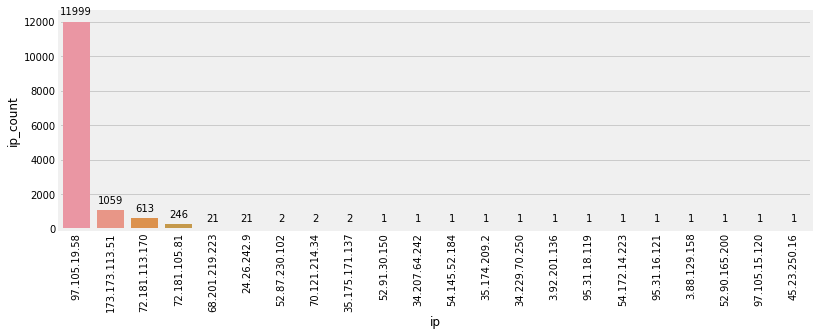

In [10]:
print(len(ip_df))

print(ip_df.tail(10))

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=ip_df, x = 'ip', y = 'ip_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

### Conditional Probabilities: probabilities using 2 discrete variables

#### Probability of Status given IP Address:
If we are looking for an unexpected status (like authentication failure) from a known/common IP address. 

In [11]:
ip_probs = df.groupby('ip').size().div(len(df))

status_given_ip = pd.DataFrame(df.groupby(['ip', 'status']).\
                               size().div(len(df)).\
                               div(ip_probs, 
                                   axis=0, 
                                   level='ip').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_status_given_ip'})
                              )

In [12]:
ip_status_count = pd.DataFrame(df.groupby(['ip', 'status'])['request_method'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'request_method': 'ip_status_count'}))

ip_status = status_given_ip.merge(ip_status_count).set_index(['ip','status'])

ip_status[(ip_status['proba_status_given_ip'] < .01) | (ip_status['ip_status_count'] < 3)]

,,proba_status_given_ip,ip_status_count
ip,status,,
3.88.129.158,200,1.000000,1
3.92.201.136,200,1.000000,1
34.207.64.242,200,1.000000,1
34.229.70.250,200,1.000000,1
35.174.209.2,200,1.000000,1
35.175.171.137,200,1.000000,2
45.23.250.16,200,1.000000,1
52.87.230.102,200,1.000000,2
52.90.165.200,200,1.000000,1


### Add these probabilities to original events to detect anomalous events

In [13]:
df = df.join(ip_status, on=['ip','status'], how='left').reset_index()

In [14]:
df = df.merge(ip_df, on='ip', how='left')

In [15]:
df.set_index('timestamp', inplace=True)
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,proba_status_given_ip,ip_status_count,ip_count,ip_proba
timestamp,,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753,0.998833,11985,11999,0.85842
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396,0.998833,11985,11999,0.85842
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.486472,0.998833,11985,11999,0.85842
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,0.486377,0.998833,11985,11999,0.85842
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,0.488246,0.998833,11985,11999,0.85842


## Isolation Forest

https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e

To use an Isolation Forest we need numeric variables. This would be considered a semisupervised learning technique. 

We also need to gather a sample of 'normal observations'.  We will start with observations that will be considered normal and will be used to train the model (training and scoring in Python’s scikit-learn implementation of Isolation Forest are analogous to all other machine learning algorithms). The second group are new observations, coming from the same distribution as the training ones. Finally, we generate the outliers.

In this example, we will look for anomalies using 2 different variables:
- Using amount of data being pulled, in megabytes (size_mb), and the probability of the given IP requesting data, we will attempt to identify anomalous events. 

#### What is normal?

In [164]:
df_norm = df['2019-04-16 19:34:42':'2019-04-17 12:55:14']
df_norm = df_norm[['ip','request_method','status','size','destination','request_agent','size_mb']]

aggregation=('median','count','max', 'min')
df_counts = df_norm.groupby(['ip', 'request_method', 'status', 'request_agent'])['size'].\
                        agg(aggregation).\
                        sort_values(by='count', ascending=False).\
                        reset_index()

In [165]:
df_counts.head(5)

,ip,request_method,status,request_agent,median,count,max,min
0,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,python-requests/2.21.0,510149.0,9007,513736,130921
1,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,python-requests/2.20.1,510142.0,1867,513736,278377
2,173.173.113.51,GET /api/v1/sales HTTP/1.1,200,python-requests/2.21.0,510317.0,815,513736,308243
3,97.105.19.58,GET /api/v1/items HTTP/1.1,200,python-requests/2.21.0,3561.0,694,3659,48
4,72.181.113.170,GET /api/v1/sales HTTP/1.1,200,python-requests/2.21.0,510328.0,507,513736,308243


**Normal:**
- occurred between '2019-04-16 19:34:42' and '2019-04-17 12:55:14'

- ip: 97.105.19.58, 173.173.113.51

- request_method: GET /api/v1/sales HTTP/1.1, GET /api/v1/items HTTP/1.1, GET /api/v1/stores HTTP/1.1

- request_agent: python-requests/2.20.1, python-requests/2.21.0

- status: 200

- destination: NAN

- size = < 520000

In [166]:
df_norm = df_norm[(df_norm.ip=='97.105.19.58') | (df_norm.ip=='173.173.113.51')]
df_norm = df_norm[df_norm.request_method.str.contains(r'^GET /api/v1/(sales|items|stores)\s+HTTP/1\.1$', 
                                                      regex=True)]
df_norm = df_norm[df_norm.status == 200]
df_norm = df_norm[df_norm.request_agent.str.contains(r'^python-requests/2\.2(0|1)\.(0|1)$',
                                                    regex=True)]
df_norm = df_norm[df_norm['size'] <= 550000]
df_norm = df_norm[pd.isnull(df_norm.destination)]

In [167]:
ip_df = pd.DataFrame(df_norm.ip.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_count'})
ip_df2 = pd.DataFrame(df_norm.ip.value_counts(dropna=False)/df_norm.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})
ip_df = ip_df.merge(ip_df2)

In [168]:
df_norm = df_norm.reset_index().merge(ip_df, on=['ip'], how='left')

In [169]:
df_norm = df_norm.set_index('timestamp')

#### Known "normal" events to train/test

In [ ]:
train = df_norm[:'2019-04-17'][['size_mb','ip_proba']]

In [175]:
df_new = df['2019-04-17 12:55:15':][['ip','request_method','status','size','destination','request_agent','size_mb']]

In [176]:
df_new = df_new.reset_index().merge(ip_df, on=['ip'], how='left').fillna(value=0)
test = df_new[['size_mb','ip_proba']]

,size_mb,ip_proba
0,1.099591,0.000000
1,0.000958,0.000000
2,0.002441,0.000000
3,1.961066,0.917383


#### Fit & Predict

1. Identify anomalous events using amount of data being pulled, in megabytes (size_mb), and the probability of the given IP requesting data

In [177]:
# fit the model
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

clf = IsolationForest(behaviour='new', max_samples=10,
                      random_state=rng, contamination='auto')
clf.fit(train)
y_pred_train = clf.predict(train)
y_pred_test = clf.predict(test)

In [180]:
pd.DataFrame({'y_pred': y_pred_test}).y_pred.value_counts()

-1    3
 1    1
Name: y_pred, dtype: int64

#### Plot the isolation forest

In [183]:
# plot the line, the samples, and the nearest vectors to the plane

def plot_clf(x, y, x_min, x_max, y_min, y_max, x_label, y_label):
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 25), np.linspace(y_min, y_max, 25))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.title("IsolationForest")
    plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
    
    b1 = plt.scatter(train[x], train[y],
                     c='white',
                     s=20, 
                     edgecolor='k')
    b2 = plt.scatter(test[x], test[y], 
                     c='red',
                     s=20, 
                     edgecolor='k')
    plt.axis('tight')
    plt.xlim((x_min, x_max))
    plt.ylim((y_min, y_max))
    plt.legend([b1, b2],
               ["original observations",
                "new observations"],
               loc="upper right")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

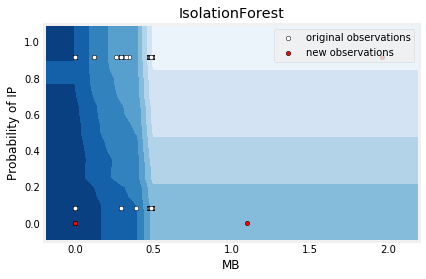

In [184]:
plot_clf('size_mb', 'ip_proba', -0.2, 2.2, -0.1, 1.1, 'MB', 'Probability of IP')

## Detecting Anomalies of Continuous Variables Using Statistical Methods

#### Anomalies in the amount of data consumed

1. resample to 30 minute intervals taking max of size
2. fill in missing datetimestamps (those not present because no data was captured during that time.  We want to have continuous time and those time periods filled with 0)

In [185]:
sns.set(style='darkgrid', context='talk', palette='Dark2')

my_datetime_fmt = mdates.DateFormatter('%m-%d %H:%T')

df_ts_size = df['size_mb'].resample('30T').max()


idx = pd.date_range(
    df_ts_size.sort_index().index.min(), 
    df_ts_size.sort_index().index.max(),
    freq='30min'
)

df_ts_size = df_ts_size.reindex(idx, fill_value=0).fillna(value=0)



#### Split into train/test

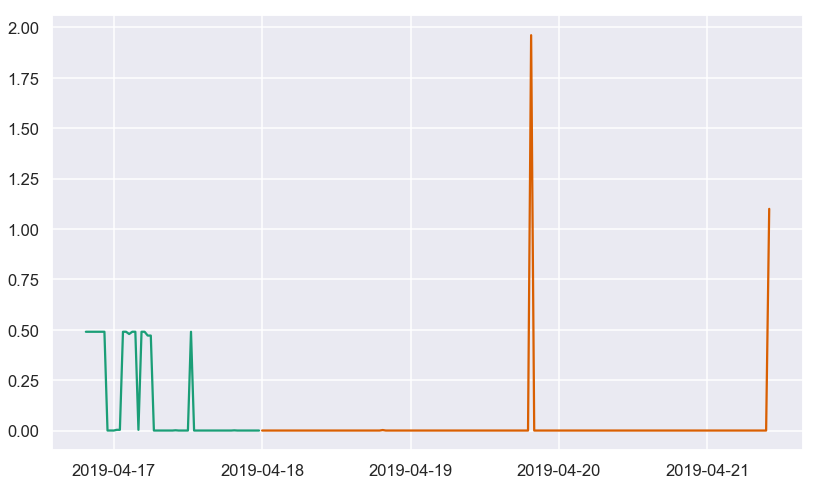

In [186]:
start_date_train = df_ts_size.head(1).index[0]
end_date_train = '2019-04-17 23:30:00'
start_date_test = '2019-04-18 00:00:00'

train = df_ts_size[:end_date_train]
test = df_ts_size[start_date_test:]

plt.figure(figsize=(12, 8))
plt.plot(train)
plt.plot(test)
plt.show()

#### SMA - Simple Moving Average

In [187]:
# Calculating the short-window simple moving average
short_rolling = train.rolling(window=12).mean()

# Calculating the long-window simple moving average
long_rolling = train.rolling(window=24).mean()

#### Plot the 2 window sizes for the SMA

Text(0, 0.5, 'Size (MB)')

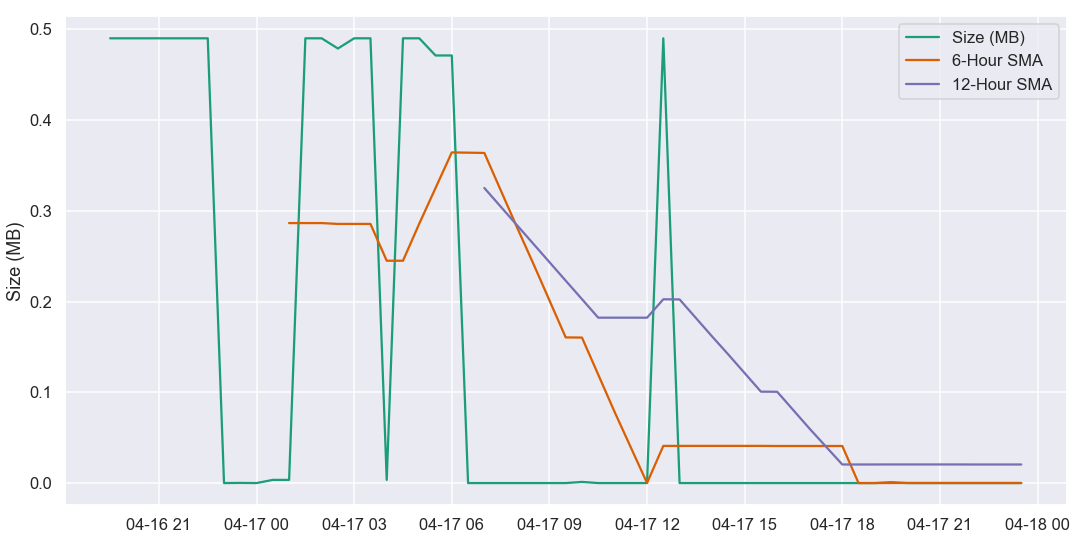

In [188]:
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(train.index, 
        train,
        label='Size (MB)')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '6-Hour SMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '12-Hour SMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')
# ax.xaxis.(rotate=90)
# ax.xaxis.set_major_formatter(my_datetime_fmt)

#### Exponential Moving Average
SMA timeseries are much less noisy than the original price timeseries. However, this comes at a cost: SMA timeseries lag the original price timeseries, which means that changes in the trend are only seen with a delay (lag) of L time units (30 minute periods in this case).

Exponential Moving Average (EMA) helps reduce the lag induced by the use of the SMA. 

$EMA(t)=(1−\alpha)EMA(t−1)+\alpha s(t)$

$EMA(t_{0})=s(t_{0})$

where $s(t)$ is the size at time $t$ and $\alpha$ is called the decay parameter for the EMA. $\alpha$ is related to the lag as:

$α=\frac{1}{L+1}$

and the length of the window (span) M as:

$\alpha = \frac{2}{M+1}$

The reason why EMA reduces the lag is that it puts more weight on more recent observations, whereas the SMA weights all observations equally by 1M. Using Pandas, calculating the exponential moving average is easy. We need to provide a lag value, from which the decay parameter $\alpha$ is automatically calculated. To be able to compare with the short-time SMA we will use a span value of 4.

#### Compute the EMA

In [189]:
# Using Pandas to calculate a 2 hour span EMA. 
# adjust=False specifies that we are interested in the 
# recursive calculation mode.
ema_short = train.ewm(span=12, adjust=False).mean()
ema_short[0:3]

ema_long = train.ewm(span=24, adjust=False).mean()
ema_long[0:3]

2019-04-16 19:30:00    0.489937
2019-04-16 20:00:00    0.489937
2019-04-16 20:30:00    0.489937
Freq: 30T, Name: size_mb, dtype: float64

#### Compare SMA with EMA

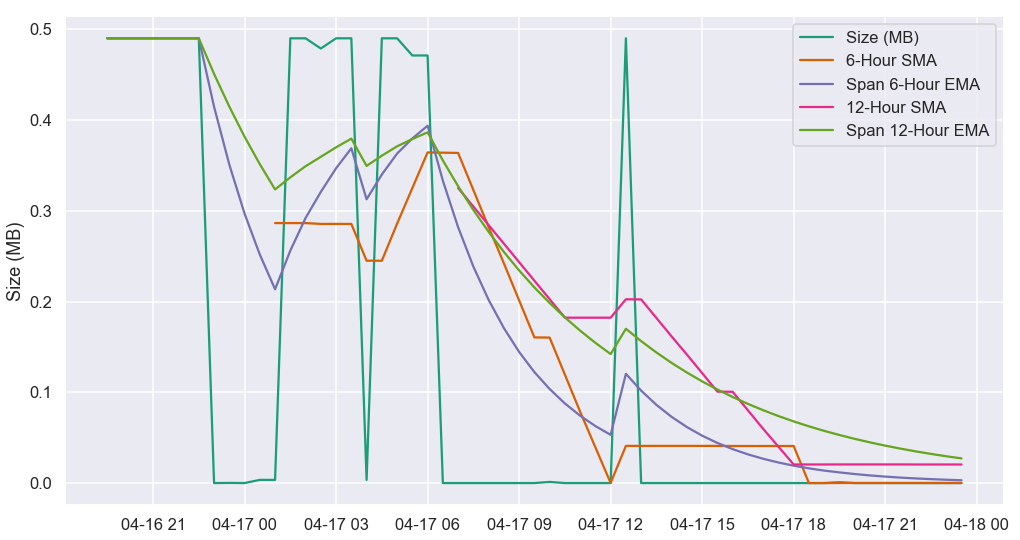

In [190]:
fig, ax = plt.subplots(figsize=(15,9))

ax.plot(train.index, 
        train,
        label='Size (MB)')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '6-Hour SMA')
ax.plot(long_rolling.index, 
        ema_short, 
        label = 'Span 6-Hour EMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '12-Hour SMA')
ax.plot(long_rolling.index, 
        ema_long, 
        label = 'Span 12-Hour EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

yhat = pd.DataFrame(dict(actual=test))

### Forecast using the EMA

In [191]:
# periods = 24
yhat['moving_avg_forecast'] = ema_long.iloc[-1]

#### Compute the '%b' for each record

In [192]:
# compute the absolute error:
yhat['error'] = abs(yhat.actual - yhat.moving_avg_forecast)

# compute the mean of the absolute error:
# yhat.error.median()

# compute upper band and lower band using IQR with weight of 3

q3 = yhat.error.describe().loc['75%']
q1 = yhat.error.describe().loc['25%']

# adding .1 to the IQR so the we don't end up with a denominator of 0. 
ub = q3 + 3*(q3-q1+.1)
lb = q1 - 3*(q3-q1+.1)

yhat['pct_b'] = (yhat.actual-lb)/(ub-lb)

#### Extract the anomalies

In [193]:
yhat[yhat.pct_b > 1]

,actual,moving_avg_forecast,error,pct_b
2019-04-19 19:30:00,1.961066,0.02718,1.933886,3.723143
2019-04-21 10:00:00,1.099591,0.02718,1.072411,2.287351


#### Plot

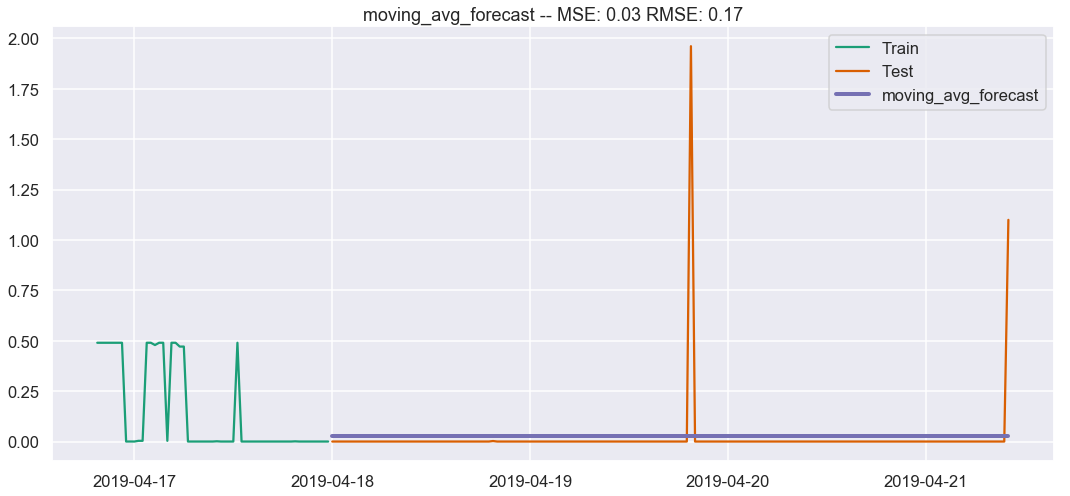

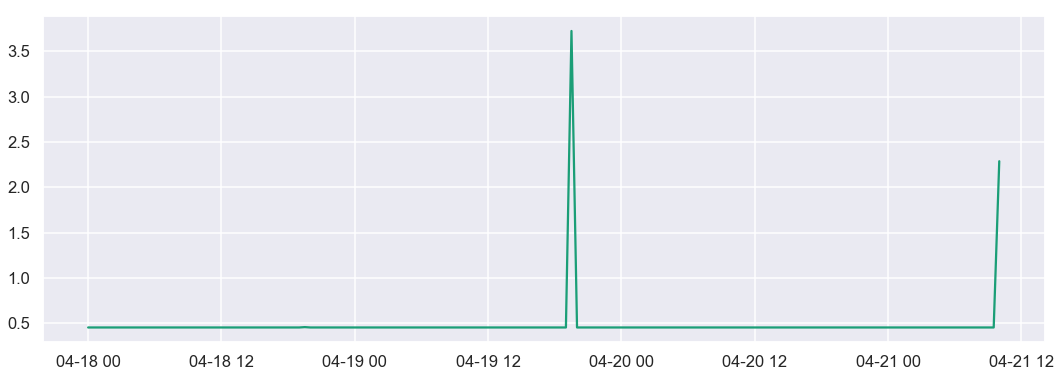

In [194]:
plot_and_eval(yhat.moving_avg_forecast, actual=test)
plt.figure(figsize=(16,6))
plt.plot(yhat.pct_b)

## Detect Anomalies using Clustering

In [195]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [196]:
# Import .csv file and convert it to a DataFrame object
df = pd.read_csv("customers.csv")

print(df.head())

   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185


In [197]:
df.drop(["Channel", "Region"], axis = 1, inplace = True)

In [198]:
df = df[["Grocery", "Milk"]]

In [199]:
np_array = df.values.astype("float32", copy = False)

Normalize each attribute by scaling it to 0 mean and unit variance. This helps to keep the inter-relationships between the features intact so that a small change in one feature would reflect in the other.

In [200]:
stscaler = StandardScaler().fit(np_array)
np_array = stscaler.transform(np_array)

construct a DBSCAN object that requires a minimum of 15 data points in a neighborhood of radius 0.5 to be considered a core point.

In [201]:
dbsc = DBSCAN(eps = .5, min_samples = 15).fit(np_array)

Next, we can extract our cluster labels and outliers to plot our results.

In [202]:
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

In [203]:
df['labels'] = labels

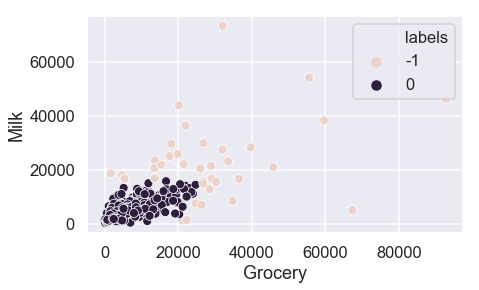

In [204]:
sns.scatterplot(df.Grocery, df.Milk, hue=df.labels)